## Twitter sentiment analysis with BART Comparaison - Exploratory Data Analysis notebook

### Import librairies

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
import string
import os

import re
import nltk
from nltk.corpus import stopwords
import warnings
warnings.filterwarnings('ignore')

# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')

# Set style for visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("deep")

[nltk_data] Downloading package punkt to /Users/photoli93/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/photoli93/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Loading data

In [2]:
# Load the dataset
# Note: Replace with actual path to your dataset
# For this example, we'll simulate loading the small dataset
def load_data():
    """Load the Twitter sentiment dataset"""
    try:
        df = pd.read_csv('../data/twitter_dataset_small_w_bart_preds.csv')
        print(f"Loaded dataset with shape: {df.shape}")
        print(f"Columns: {df.columns.tolist()}")
        return df
    except FileNotFoundError:
        print("Dataset file not found. Please ensure the file path is correct.")

df = load_data()
print("\nDataset Info:")
print(df.info())
print("\nFirst few rows:")
display(df.sample(5))

Loaded dataset with shape: (20000, 6)
Columns: ['is_positive', 'id', 'datetime', 'user', 'message', 'bart_is_positive']

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   is_positive       20000 non-null  int64  
 1   id                20000 non-null  int64  
 2   datetime          20000 non-null  object 
 3   user              20000 non-null  object 
 4   message           20000 non-null  object 
 5   bart_is_positive  20000 non-null  float64
dtypes: float64(1), int64(2), object(3)
memory usage: 937.6+ KB
None

First few rows:


,is_positive,id,datetime,user,message,bart_is_positive
9564,0,1573301786,Tue Apr 21 00:33:27 PDT 2009,richstokes,at work after a nice 3 day weekend boo!,0.000673
16093,0,1995862292,Mon Jun 01 14:09:48 PDT 2009,ChrissyRichter,woooo lalalaa i watch tv with my sister and do...,0.000579
12070,1,2049949137,Fri Jun 05 17:47:27 PDT 2009,crazyyg,oh my family guy is so outrageous.. i love it,0.728908
13334,1,1969934163,Sat May 30 01:47:24 PDT 2009,greekdude,@iamaline yeah! as well as cherry tree and fig...,0.941332
12029,1,2174720065,Sun Jun 14 23:09:42 PDT 2009,KatieeJack,morning twitter,0.761566


### Exploratory data analysis

#### Quick dataset overview

In [3]:
def data_overview(df):
    """Perform quick overview data analysis"""
    
    print("=== Dataset overview ===")
    print(f"Total samples: {len(df)}")
    print(f"Features: {df.columns.tolist()}")
    
    # Check for missing values
    print("\n=== Missing values ===")
    print(df.isnull().sum())
    
    # Target variable distribution
    print("\n=== Target variable distribution ===")
    target_counts = df['is_positive'].value_counts()
    print(target_counts)
    print(f"Positive ratio: {target_counts[1] / len(df):.3f}")

    # Duplicate analysis
    print(f"\n=== Duplicate Analysis ===")
    duplicate_count = df.duplicated().sum()
    duplicate_text_count = df['message'].duplicated().sum()
    print(f"Complete duplicates: {duplicate_count:,}")
    print(f"Text duplicates: {duplicate_text_count:,}")
    
    if duplicate_text_count > 0:
        print("Sample duplicate texts:")
        duplicate_texts = df[df['message'].duplicated(keep=False)]['message'].value_counts().head(3)
        for text, count in duplicate_texts.items():
            print(f"  '{text[:100]}...' appears {count} times")

data_overview(df)

=== Dataset overview ===
Total samples: 20000
Features: ['is_positive', 'id', 'datetime', 'user', 'message', 'bart_is_positive']

=== Missing values ===
is_positive         0
id                  0
datetime            0
user                0
message             0
bart_is_positive    0
dtype: int64

=== Target variable distribution ===
is_positive
1    10058
0     9942
Name: count, dtype: int64
Positive ratio: 0.503

=== Duplicate Analysis ===
Complete duplicates: 0
Text duplicates: 21
Sample duplicate texts:
  'Good morning ...' appears 4 times
  'Goodnight ...' appears 3 times
  'Headache ...' appears 3 times


#### Text statistics analysis

In [4]:
def text_statistics_analysis(df):
    """Detailed text statistics analysis"""

    df['text_length'] = df['message'].str.len()
    df['word_count'] = df['message'].str.split().str.len()
    df['sentence_count'] = df['message'].str.count(r'[.!?]+') + 1
    df['avg_word_length'] = df['message'].apply(lambda x: np.mean([len(word) for word in x.split()]) if x.split() else 0)
    df['punctuation_count'] = df['message'].apply(lambda x: sum([1 for char in x if char in string.punctuation]))
    df['capital_letters_count'] = df['message'].str.count(r'[A-Z]')
    df['exclamation_count'] = df['message'].str.count('!')
    df['question_count'] = df['message'].str.count(r'\?')
    df['url_count'] = df['message'].str.count(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    df['mention_count'] = df['message'].str.count(r'@\w+')
    df['hashtag_count'] = df['message'].str.count(r'#\w+')
    
    text_features = ['text_length', 'word_count', 'sentence_count', 'avg_word_length', 
                    'punctuation_count', 'capital_letters_count', 'exclamation_count', 
                    'question_count', 'url_count', 'mention_count', 'hashtag_count']
    
    print("\n=== Overall Text Statistics ===")
    display(df[text_features].describe().round(2))
    
    # Statistics by sentiment
    print("\n=== Text Statistics by Sentiment ===")
    for sentiment in [0, 1]:
        sentiment_name = "Negative" if sentiment == 0 else "Positive"
        subset = df[df['is_positive'] == sentiment]
        print(f"\n{sentiment_name} Texts ({len(subset):,} samples):")
        display(subset[text_features].describe().round(2))
    
    return text_features

text_features = text_statistics_analysis(df)


=== Overall Text Statistics ===


,text_length,word_count,sentence_count,avg_word_length,punctuation_count,capital_letters_count,exclamation_count,question_count,url_count,mention_count,hashtag_count
count,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00
mean,74.32,13.21,2.35,4.87,4.01,3.27,0.57,0.16,0.04,0.49,0.03
std,36.39,6.95,1.23,1.35,3.49,5.25,1.41,1.09,0.21,0.60,0.18
min,7.00,1.00,1.00,1.43,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,44.00,7.00,1.00,4.09,2.00,1.00,0.00,0.00,0.00,0.00,0.00
50%,70.00,12.00,2.00,4.60,3.00,2.00,0.00,0.00,0.00,0.00,0.00
75%,104.00,19.00,3.00,5.29,6.00,4.00,1.00,0.00,0.00,1.00,0.00
max,222.00,41.00,21.00,45.33,89.00,105.00,74.00,88.00,4.00,9.00,5.00



=== Text Statistics by Sentiment ===

Negative Texts (9,942 samples):


,text_length,word_count,sentence_count,avg_word_length,punctuation_count,capital_letters_count,exclamation_count,question_count,url_count,mention_count,hashtag_count
count,9942.00,9942.00,9942.00,9942.00,9942.00,9942.00,9942.00,9942.00,9942.00,9942.00,9942.00
mean,74.20,13.56,2.31,4.65,3.77,3.04,0.48,0.15,0.03,0.40,0.02
std,36.71,7.07,1.20,1.22,3.23,5.22,1.17,0.61,0.17,0.53,0.18
min,8.00,1.00,1.00,1.43,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,44.00,8.00,1.00,4.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00
50%,70.00,13.00,2.00,4.44,3.00,2.00,0.00,0.00,0.00,0.00,0.00
75%,104.00,19.00,3.00,5.00,5.00,4.00,1.00,0.00,0.00,1.00,0.00
max,162.00,33.00,12.00,45.33,51.00,105.00,27.00,29.00,2.00,7.00,5.00



Positive Texts (10,058 samples):


,text_length,word_count,sentence_count,avg_word_length,punctuation_count,capital_letters_count,exclamation_count,question_count,url_count,mention_count,hashtag_count
count,10058.00,10058.00,10058.00,10058.00,10058.00,10058.00,10058.00,10058.00,10058.00,10058.00,10058.00
mean,74.44,12.87,2.40,5.08,4.24,3.49,0.67,0.17,0.06,0.59,0.03
std,36.07,6.81,1.26,1.44,3.71,5.27,1.60,1.41,0.25,0.64,0.19
min,7.00,1.00,1.00,1.92,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,44.00,7.00,1.00,4.24,2.00,1.00,0.00,0.00,0.00,0.00,0.00
50%,70.00,12.00,2.00,4.79,3.00,2.00,0.00,0.00,0.00,1.00,0.00
75%,104.00,18.00,3.00,5.50,6.00,4.00,1.00,0.00,0.00,1.00,0.00
max,222.00,41.00,21.00,23.80,89.00,100.00,74.00,88.00,4.00,9.00,4.00


#### Sentiment distribution analysis

In [5]:
def sentiment_distribution_analysis(df):
    """Analyze sentiment distribution patterns"""
    
    sentiment_counts = df['is_positive'].value_counts()
    print(f"\n=== Basic Sentiment Distribution ===")
    print(f"Negative (0): {sentiment_counts[0]:,} ({sentiment_counts[0]/len(df)*100:.2f}%)")
    print(f"Positive (1): {sentiment_counts[1]:,} ({sentiment_counts[1]/len(df)*100:.2f}%)")
    
    # Test if the target is imbalanced
    imbalance_ratio = sentiment_counts.max() / sentiment_counts.min()
    print(f"Imbalance ratio: {imbalance_ratio:.2f}:1")
    
    if imbalance_ratio > 1.5:
        print("Dataset is imbalanced - consider resampling techniques")
    else:
        print("Dataset is relatively balanced")
    
    # BART predictions comparison
    if 'bart_is_positive' in df.columns:
        print(f"\n=== BART vs Ground Truth Comparison ===")

        df['bart_pred'] = (df['bart_is_positive'] >= 0.5).astype(int)
        bart_counts = df['bart_pred'].value_counts()

        print(f"BART Negative: {bart_counts[0]:,} ({bart_counts[0]/len(df)*100:.2f}%)")
        print(f"BART Positive: {bart_counts[1]:,} ({bart_counts[1]/len(df)*100:.2f}%)")
        
        # Accuracy analysis
        accuracy = (df['is_positive'] == df['bart_pred']).mean()
        print(f"BART-Ground Truth accuracy: {accuracy:.3f}")
        
        # Confusion matrix for BART
        bart_confusion = pd.crosstab(df['is_positive'], df['bart_pred'], 
                                   rownames=['Ground Truth'], colnames=['BART Prediction'])
        print(f"\nBART Confusion Matrix:")
        display(bart_confusion)

sentiment_distribution_analysis(df)


=== Basic Sentiment Distribution ===
Negative (0): 9,942 (49.71%)
Positive (1): 10,058 (50.29%)
Imbalance ratio: 1.01:1
Dataset is relatively balanced

=== BART vs Ground Truth Comparison ===
BART Negative: 13,890 (69.45%)
BART Positive: 6,110 (30.55%)
BART-Ground Truth accuracy: 0.710

BART Confusion Matrix:


BART Prediction,0,1
Ground Truth,,
0,9017,925
1,4873,5185


#### Comprehensive visualization

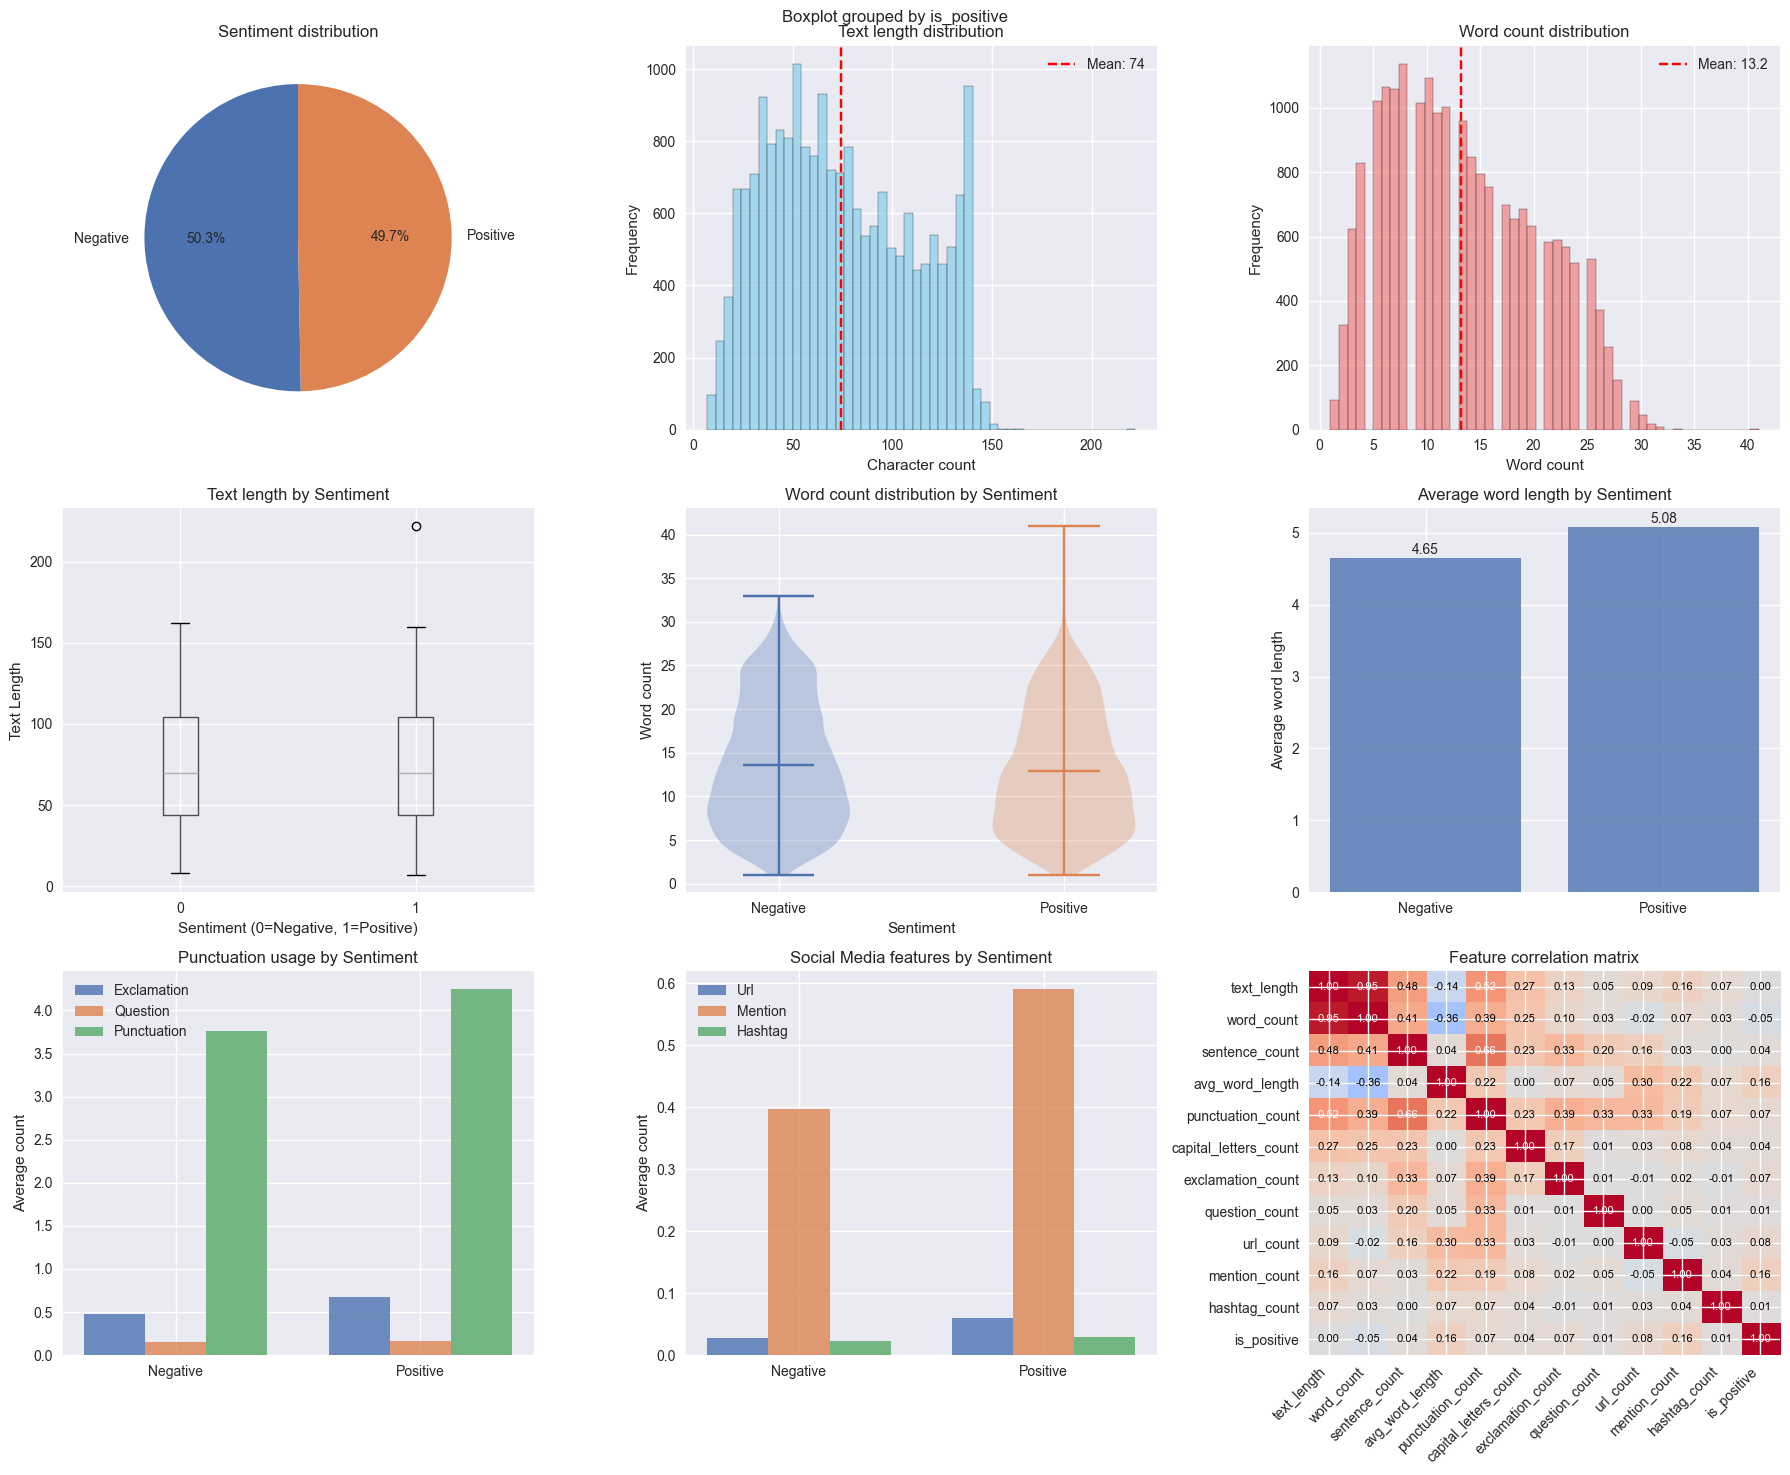

In [6]:
def create_comprehensive_visualizations(df, text_features):
    """Create comprehensive visualizations"""

    fig, axes = plt.subplots(3, 3, figsize=(18, 15))
    fig.suptitle('Comprehensive text analysis dashboard', fontsize=16, fontweight='bold')
    
    # Target distribution
    sentiment_counts = df['is_positive'].value_counts()
    axes[0,0].pie(sentiment_counts.values, labels=['Negative', 'Positive'], autopct='%1.1f%%',
                  startangle=90)
    axes[0,0].set_title('Sentiment distribution')
    
    # Text length distribution
    axes[0,1].hist(df['text_length'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0,1].set_title('Text length distribution')
    axes[0,1].set_xlabel('Character count')
    axes[0,1].set_ylabel('Frequency')
    axes[0,1].axvline(df['text_length'].mean(), color='red', linestyle='--', label=f'Mean: {df["text_length"].mean():.0f}')
    axes[0,1].legend()
    
    # Word count distribution
    axes[0,2].hist(df['word_count'], bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
    axes[0,2].set_title('Word count distribution')
    axes[0,2].set_xlabel('Word count')
    axes[0,2].set_ylabel('Frequency')
    axes[0,2].axvline(df['word_count'].mean(), color='red', linestyle='--', label=f'Mean: {df["word_count"].mean():.1f}')
    axes[0,2].legend()
    
    # Text length by sentiment
    df.boxplot(column='text_length', by='is_positive', ax=axes[1,0])
    axes[1,0].set_title('Text length by Sentiment')
    axes[1,0].set_xlabel('Sentiment (0=Negative, 1=Positive)')
    axes[1,0].set_ylabel('Text Length')
    
    # Word count by sentiment
    sentiment_labels = ['Negative', 'Positive']
    for i, sentiment in enumerate([0, 1]):
        data = df[df['is_positive'] == sentiment]['word_count']
        axes[1,1].violinplot([data], positions=[i], showmeans=True, showextrema=True)
    axes[1,1].set_title('Word count distribution by Sentiment')
    axes[1,1].set_xlabel('Sentiment')
    axes[1,1].set_ylabel('Word count')
    axes[1,1].set_xticks([0, 1])
    axes[1,1].set_xticklabels(sentiment_labels)
    
    # Average word length by sentiment
    avg_word_length_by_sentiment = df.groupby('is_positive')['avg_word_length'].mean()
    axes[1,2].bar(sentiment_labels, avg_word_length_by_sentiment.values,
                  alpha=0.8)
    axes[1,2].set_title('Average word length by Sentiment')
    axes[1,2].set_ylabel('Average word length')
    for i, v in enumerate(avg_word_length_by_sentiment.values):
        axes[1,2].text(i, v + 0.01, f'{v:.2f}', ha='center', va='bottom')
    
    # Punctuation usage
    punctuation_features = ['exclamation_count', 'question_count', 'punctuation_count']
    punct_by_sentiment = df.groupby('is_positive')[punctuation_features].mean()

    x = np.arange(len(sentiment_labels))
    width = 0.25
    
    offsets = np.linspace(-width, width, len(punctuation_features))

    for i, feature in enumerate(punctuation_features):
        axes[2,0].bar(x + offsets[i], punct_by_sentiment[feature], 
                    width=width, label=feature.replace('_count', '').title(), alpha=0.8)

    axes[2,0].set_xticks(x)
    axes[2,0].set_xticklabels(['Negative', 'Positive'])
    axes[2,0].set_title('Punctuation usage by Sentiment')
    axes[2,0].set_ylabel('Average count')
    axes[2,0].legend()
    
    # Social media features
    social_features = ['url_count', 'mention_count', 'hashtag_count']
    social_by_sentiment = df.groupby('is_positive')[social_features].mean()

    x = np.arange(len(sentiment_labels))
    width = 0.25
    offsets = np.linspace(-width, width, len(social_features))

    for i, feature in enumerate(social_features):
        axes[2,1].bar(x + offsets[i], social_by_sentiment[feature], 
                    width=width, label=feature.replace('_count', '').title(), alpha=0.8)

    axes[2,1].set_xticks(x)
    axes[2,1].set_xticklabels(['Negative', 'Positive'])
    axes[2,1].set_title('Social Media features by Sentiment')
    axes[2,1].set_ylabel('Average count')
    axes[2,1].legend()
    
    # Correlation of text features with a heatmap
    correlation_matrix = df[text_features + ['is_positive']].corr()
    im = axes[2,2].imshow(correlation_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
    axes[2,2].set_title('Feature correlation matrix')
    axes[2,2].set_xticks(range(len(correlation_matrix.columns)))
    axes[2,2].set_yticks(range(len(correlation_matrix.columns)))
    axes[2,2].set_xticklabels(correlation_matrix.columns, rotation=45, ha='right')
    axes[2,2].set_yticklabels(correlation_matrix.columns)
    
    # Add correlation values to heatmap
    for i in range(len(correlation_matrix.columns)):
        for j in range(len(correlation_matrix.columns)):
            axes[2,2].text(j, i, f'{correlation_matrix.iloc[i, j]:.2f}', 
                          ha='center', va='center', color='white' if abs(correlation_matrix.iloc[i, j]) > 0.5 else 'black',
                          fontsize=8)
    
    plt.tight_layout()

    plt.show()
    
    return correlation_matrix

correlation_matrix = create_comprehensive_visualizations(df, text_features)

#### Word frequency analysis


=== Overall word frequency (Top 5) ===
good: 1,173
day: 1,069
get: 1,042
like: 969
quot: 924

=== Positive Sentiment top words ===
good: 806
love: 615
http: 608
day: 607
quot: 560

=== Negative Sentiment top words ===
get: 559
work: 555
go: 546
like: 488
today: 462

=== Distinctive words analysis ===
Most distinctive POSITIVE words:
  jnylin: 1.000
  wing: 1.000
  endurance: 1.000
  totes: 1.000
  sjltq: 1.000
  adidas: 1.000
  babelfish: 1.000
  tiffanywon: 1.000
  oranges: 1.000
  teaser: 1.000
  whacky: 1.000
  barbeque: 1.000
  totalgirlph: 1.000
  rebranded: 1.000
  scruffypanther: 1.000

Most distinctive NEGATIVE words:
  overwhelmed: -1.000
  gita: -1.000
  llaeak: -1.000
  jld6574: -1.000
  expectantly: -1.000
  syracuse: -1.000
  pockets: -1.000
  tenho: -1.000
  garruk: -1.000
  kingofbrooklyn: -1.000
  dexime: -1.000
  laurenn_: -1.000
  defended: -1.000
  connectivity: -1.000
  yaykimo: -1.000


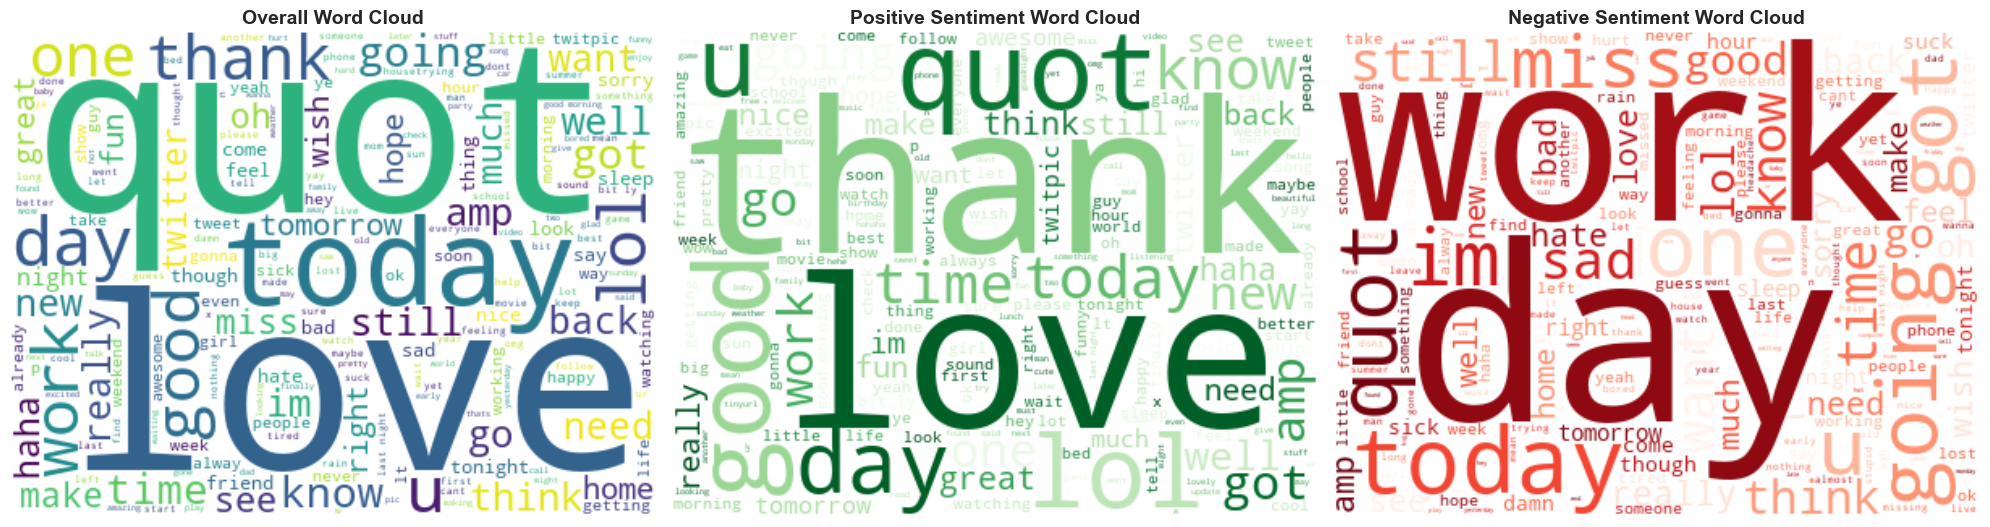

In [7]:
def word_frequency_analysis(df):
    """Analyze word frequencies and create word clouds"""

    sw = set(stopwords.words('english'))

    def clean_text_for_analysis(message):
        if pd.isna(message):
            return ""
        # Convert to lowercase and remove punctuation
        message = message.lower()
        message = re.sub(r'[^\w\s]', ' ', message)
        message = re.sub(r'\s+', ' ', message).strip()
        return message
    
    df['clean_text'] = df['message'].apply(clean_text_for_analysis)
    
    # Remove stopwords
    def remove_stopwords(text):
        return ' '.join([word for word in text.split() if word not in sw])
    
    df['clean_text'] = df['clean_text'].apply(remove_stopwords)

    # Overall word frequency
    all_words = ' '.join(df['clean_text']).split()
    word_freq = Counter(all_words)
    
    print(f"\n=== Overall word frequency (Top 5) ===")
    for word, count in word_freq.most_common(5):
        print(f"{word}: {count:,}")
    
    # Word frequency by sentiment
    positive_texts = df[df['is_positive'] == 1]['clean_text']
    negative_texts = df[df['is_positive'] == 0]['clean_text']
    
    positive_words = ' '.join(positive_texts).split()
    negative_words = ' '.join(negative_texts).split()
    
    positive_freq = Counter(positive_words)
    negative_freq = Counter(negative_words)
    
    print(f"\n=== Positive Sentiment top words ===")
    for word, count in positive_freq.most_common(5):
        print(f"{word}: {count:,}")
    
    print(f"\n=== Negative Sentiment top words ===")
    for word, count in negative_freq.most_common(5):
        print(f"{word}: {count:,}")
    
    # Find distinctive words for each sentiment
    print(f"\n=== Distinctive words analysis ===")
    
    # Calculate relative frequency differences
    all_unique_words = set(positive_freq.keys()) | set(negative_freq.keys())
    total_pos_words = sum(positive_freq.values())
    total_neg_words = sum(negative_freq.values())
    
    word_distinctiveness = {}
    for word in all_unique_words:
        pos_ratio = positive_freq.get(word, 0) / total_pos_words
        neg_ratio = negative_freq.get(word, 0) / total_neg_words
        if pos_ratio + neg_ratio > 0:
            distinctiveness = (pos_ratio - neg_ratio) / (pos_ratio + neg_ratio)
            word_distinctiveness[word] = distinctiveness
    
    # Most distinctive positive words
    positive_distinctive = sorted(word_distinctiveness.items(), key=lambda x: x[1], reverse=True)[:15]
    print("Most distinctive POSITIVE words:")
    for word, score in positive_distinctive:
        print(f"  {word}: {score:.3f}")
    
    # Most distinctive negative words
    negative_distinctive = sorted(word_distinctiveness.items(), key=lambda x: x[1])[:15]
    print("\nMost distinctive NEGATIVE words:")
    for word, score in negative_distinctive:
        print(f"  {word}: {score:.3f}")
    
# Create word clouds
    try:
        from wordcloud import WordCloud
        
        fig, axes = plt.subplots(1, 3, figsize=(20, 6))

        # Overall word cloud
        if len(all_words) > 0:
            wordcloud_all = WordCloud(width=400, height=300, background_color='white').generate(' '.join(all_words))
            axes[0].imshow(wordcloud_all, interpolation='bilinear')
            axes[0].set_title('Overall Word Cloud', fontsize=14, fontweight='bold')
            axes[0].axis('off')
        
        # Positive word cloud
        if len(positive_words) > 0:
            wordcloud_pos = WordCloud(width=400, height=300, background_color='white', 
                                    colormap='Greens').generate(' '.join(positive_words))
            axes[1].imshow(wordcloud_pos, interpolation='bilinear')
            axes[1].set_title('Positive Sentiment Word Cloud', fontsize=14, fontweight='bold')
            axes[1].axis('off')
        
        # Negative word cloud
        if len(negative_words) > 0:
            wordcloud_neg = WordCloud(width=400, height=300, background_color='white', 
                                    colormap='Reds').generate(' '.join(negative_words))
            axes[2].imshow(wordcloud_neg, interpolation='bilinear')
            axes[2].set_title('Negative Sentiment Word Cloud', fontsize=14, fontweight='bold')
            axes[2].axis('off')
        
        plt.tight_layout()
        plt.show()
        
    except ImportError:
        print("WordCloud library not available. Install with: pip install wordcloud")
    
    return word_freq, positive_freq, negative_freq, word_distinctiveness

word_freq, positive_freq, negative_freq, word_distinctiveness = word_frequency_analysis(df)


"today", "love", "work", "day" dominate the overall word cloud \
This suggests the dataset contains a lot of personal, everyday communication about daily activities and relationships

"love", "thank", "good", "fun", "great" dominate the positive sentiment word cloud \
The size of "love" suggests strong emotional expression in positive messages and words like "thank", "fun", "well" indicate gratitude and approval

"day", "work", "damn", "hate", "sad" \
There is less emotionally charged language compared to the positive sentiment word cloud, more neutral words ("got", "day", "still") and the presence of "hate", "sad" (smaller but visible) shows some strong negative emotions

#### Export dataset for Preprocessing, Feature Engineering and Model Training

In [10]:
folder_path = "../data/"
os.makedirs(folder_path, exist_ok=True)

df.to_csv(os.path.join(folder_path, 'dataset_twitter_classification.csv'), index=False)